In [1]:
#引入相关模块
#读取数据用的模块
from pandas_datareader import data as pdr
#数据预处理用的模块
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
#建立模型用的模块
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, TimeDistributed
#作图用的模块
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes='Ture')

In [2]:
#根据股票代码BILI,从雅虎财经上获取从2018-3-28到2020-8-18的股票数据
df=pdr.get_data_yahoo('BILI',start='2018-03-28',end='2020-08-18')
#查看数据
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-03-28,11.260000,9.620000,9.800000,11.240000,23929600,11.240000
2018-03-29,11.800000,10.650000,11.500000,11.000000,5863900,11.000000
2018-04-02,11.500000,10.910000,11.050000,11.000000,2771000,11.000000
2018-04-03,11.500000,10.791000,11.500000,10.910000,2509600,10.910000
2018-04-04,11.080000,10.550000,10.750000,10.970000,1498200,10.970000
...,...,...,...,...,...,...
2020-08-12,41.419998,40.284000,40.730000,40.939999,2644200,40.939999
2020-08-13,42.189999,41.119999,41.599998,41.750000,3805700,41.750000
2020-08-14,42.419998,40.900002,41.939999,41.580002,2892700,41.580002


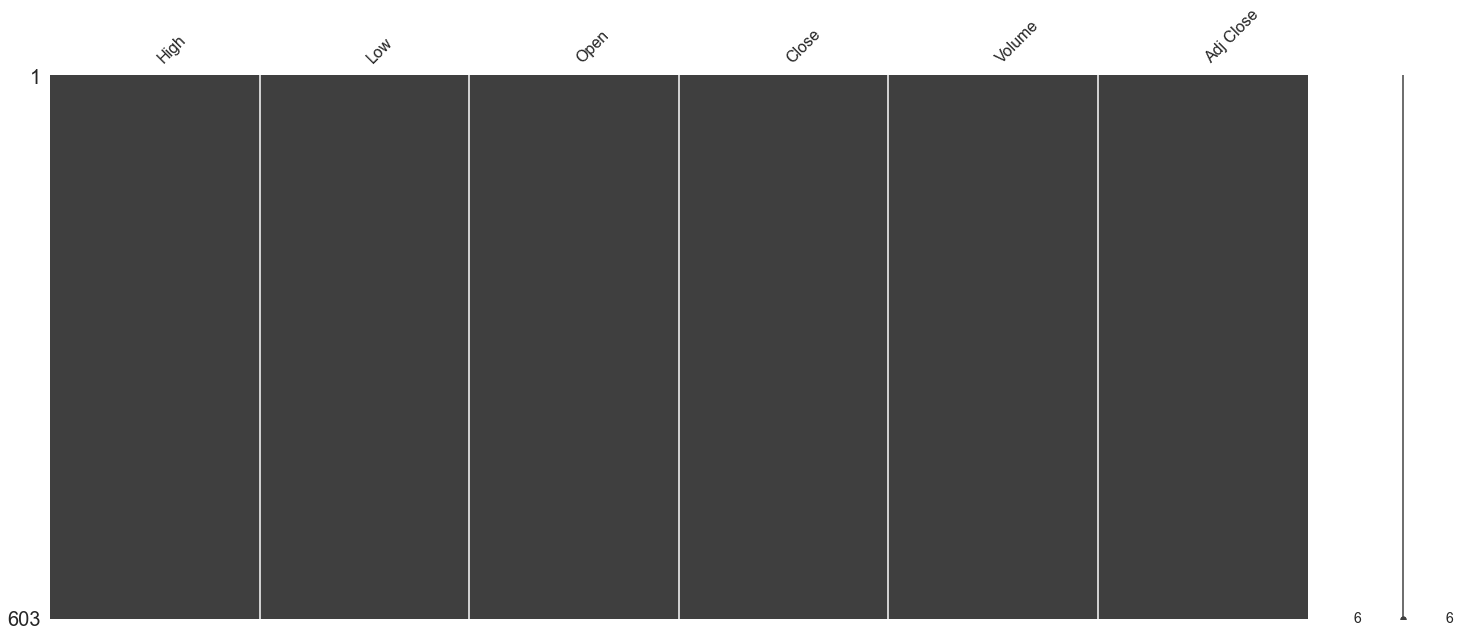

In [3]:
#可视化缺失值
msno.matrix(df)

In [4]:
# 将dataframe按索引降序排列
data = df.sort_index(ascending=True, axis=0)
#只用Close这一列，即只使用股票的收盘价来进行拟合和预测
dataset=data[['Close']].values

#取80%的数据作为训练集
training_data_len=math.ceil(len(dataset)*.8)
train_data=dataset[0:training_data_len,:]
#取剩下的数据作为测试集
#在做预测时，余下的数据的第一个数据，需要前60天的数据来预测，因此这倒溯了60天
test_data = dataset[training_data_len-60: , : ]

In [5]:
#特征缩放
scaler=MinMaxScaler(feature_range=(0,1))
scaled_train=scaler.fit_transform(train_data)
scaled_test=scaler.fit_transform(test_data)

In [6]:
#训练集的重构
#1 分离x和y
x_train=[]
y_train=[]
for i in range(60,len(scaled_train)):
    x_train.append(scaled_train[i-60:i,0])
    y_train.append(scaled_train[i,0])
#2 将list类型数据转变成array数据
x_train,y_train=np.array(x_train),np.array(y_train)

#3 将二维数据变成三维数据
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [7]:
#测试集的重构
#1 分离x和y
x_test = []
y_test = dataset[training_data_len: , : ] 
for i in range(60,len(scaled_test)):
    x_test.append(scaled_test[i-60:i,0])
#2 将list类型数据转变成array数据
x_test = np.array(x_test)
#3 将二维数据变成三维数据
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [8]:
#构建模型
#初始化模型
model = Sequential()
#LSTM层
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
#Dropout层
model.add(Dropout(.2))
#LSTM层
model.add(LSTM(units=50, return_sequences=False))
#Dropout层
model.add(Dropout(.2))
#全连接层
model.add(Dense(units=1))
#模型编译
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
#模型结构
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [10]:
#拟合模型
model.fit(x_train, y_train, batch_size=25, epochs=10)

Epoch 1/10
17/17 [==============================] - 1s 83ms/step - loss: 0.0386
Epoch 2/10
17/17 [==============================] - 1s 81ms/step - loss: 0.0109
Epoch 3/10
17/17 [==============================] - 1s 80ms/step - loss: 0.0071
Epoch 4/10
17/17 [==============================] - 1s 77ms/step - loss: 0.0057
Epoch 5/10
17/17 [==============================] - 1s 78ms/step - loss: 0.0065
Epoch 6/10
17/17 [==============================] - 1s 79ms/step - loss: 0.0058
Epoch 7/10
17/17 [==============================] - 1s 78ms/step - loss: 0.0053
Epoch 8/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0051
Epoch 9/10
17/17 [==============================] - 1s 76ms/step - loss: 0.0054
Epoch 10/10
17/17 [==============================] - 1s 77ms/step - loss: 0.0049


In [11]:
#预测
predictions = model.predict(x_test) 
#还原 特征缩放
predictions = scaler.inverse_transform(predictions)

d:\python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


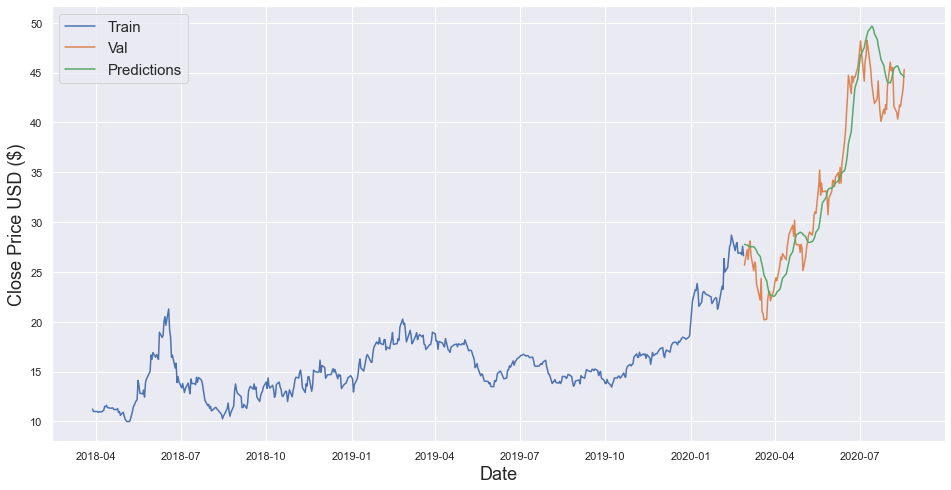

In [12]:
#创建用来画图的dataframe
train = data[:training_data_len]
valid = data[training_data_len:]
#给valid添加新的一列，把预测值predictions赋值给新的一列
valid['Predictions'] = predictions
#开始作图
#图像大小
plt.figure(figsize=(16,8))
#x轴
plt.xlabel('Date', fontsize=18)
#y轴
plt.ylabel('Close Price USD ($)', fontsize=18)
#画训练集的折线图
plt.plot(train['Close'])
#分别画出真实值和预测值的折线图
plt.plot(valid[['Close', 'Predictions']])
#展示图例
plt.legend(['Train', 'Val', 'Predictions'],fontsize=15)
plt.show()